# 전이학습 nbeats, lstm 비교

`-` nbeats 전이학습 소스코드 출처

- https://github.com/unit8co/darts/blob/master/examples/14-transfer-learning.ipynb


---

# import

In [2]:
%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

import os
import time
import random
import pandas as pd
import pickle
import numpy as np
from tqdm.auto import tqdm
from datetime import datetime
from itertools import product
import torch
from torch import nn
from typing import List, Tuple, Dict, Optional
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.losses import SmapeLoss
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode
from darts.models import *

In [3]:
HORIZON = 18

---

# load pretrained data 

In [4]:
def load_m4(
    max_number_series: Optional[int] = None,
) -> Tuple[List[TimeSeries], List[TimeSeries]]:
    """
    Due to the size of the dataset, this function takes approximately 10 minutes.

    Use the `max_number_series` parameter to reduce the computation time if necessary
    """
    # Read data dataFrame
    df_m4 = pd.read_csv("m4_monthly.csv")
    if max_number_series is not None:
        df_m4 = df_m4[:max_number_series]
    # Read metadata dataframe
    df_meta = pd.read_csv("m4_metadata.csv")
    df_meta = df_meta.loc[df_meta.SP == "Monthly"]

    # Build TimeSeries
    m4_train = []
    m4_test = []
    for row in tqdm(df_m4.iterrows(), total=len(df_m4)):
        s = row[1]
        values_series = s[1:].dropna()
        start_date = pd.Timestamp(
            df_meta.loc[df_meta["M4id"] == "M1", "StartingDate"].values[0]
        )
        time_axis = pd.date_range(start_date, periods=len(values_series), freq="M")
        series = TimeSeries.from_times_and_values(
            time_axis, values_series.values
        ).astype(np.float32)
        # remove series with less than 48 training samples
        if len(series) > 48 + HORIZON:
            # Split train/test
            m4_train.append(series[:-HORIZON])
            m4_test.append(series[-HORIZON:])

    print("\nThere are {} monthly series in the M3 dataset".format(len(m4_train)))

    # Scale so that the largest value is 1
    print("scaling...")
    scaler_m4 = Scaler(scaler=MaxAbsScaler())
    m4_train_scaled: List[TimeSeries] = scaler_m4.fit_transform(m4_train)
    m4_test_scaled: List[TimeSeries] = scaler_m4.transform(m4_test)

    print(
        "done. There are {} series, with average training length {}".format(
            len(m4_train_scaled), np.mean([len(s) for s in m4_train_scaled])
        )
    )
    return m4_train_scaled, m4_test_scaled

In [7]:
m4_train, m4_test = load_m4()

  0%|          | 0/48000 [00:00<?, ?it/s]


There are 47087 monthly series in the M3 dataset
scaling...
done. There are 47087 series, with average training length 201.25202285131778



---

# load target data

In [144]:
def load_air() -> Tuple[List[TimeSeries], List[TimeSeries]]:
    # download csv file
    df = pd.read_csv("carrier_passengers.csv")
    # extract relevant columns
    df = df[["data_dte", "carrier", "Total"]]
    # aggregate per carrier and date
    df = pd.DataFrame(df.groupby(["carrier", "data_dte"]).sum())
    # move indexes to columns
    df = df.reset_index()

    # group bt carrier, specificy time index and target variable
    all_air_series = TimeSeries.from_group_dataframe(
        df, group_cols="carrier", time_col="data_dte", value_cols="Total", freq="MS"
    )

    # Split train/test
    print("splitting train/test...")
    air_train = []
    air_test = []
    for series in all_air_series:
        # remove the end of the series
        series = series[: pd.Timestamp("2019-12-31")]
        # convert to proper type
        series = series.astype(np.float32)
        # extract longest contiguous slice
        try:
            series = series.longest_contiguous_slice()
        except:
            continue
        # remove static covariates
        series = series.with_static_covariates(None)
        # remove short series
        if len(series) >= 36 + HORIZON:
            air_train.append(series[:-HORIZON])
            air_test.append(series[-HORIZON:])

    # Scale so that the largest value is 1
    print("scaling series...")
    scaler_air = Scaler(scaler=MaxAbsScaler())
    air_train_scaled: List[TimeSeries] = scaler_air.fit_transform(air_train)
    air_test_scaled: List[TimeSeries] = scaler_air.transform(air_test)

    print(
        "done. There are {} series, with average training length {}".format(
            len(air_train_scaled), np.mean([len(s) for s in air_train_scaled])
        )
    )
    return air_train_scaled, air_test_scaled


`-` nbeats input data

In [383]:
air_train, air_test = load_air()

splitting train/test...


ERROR:darts.timeseries:IndexError: The type of your index was not matched.
ERROR:darts.timeseries:IndexError: The type of your index was not matched.
ERROR:darts.timeseries:IndexError: The type of your index was not matched.
ERROR:darts.timeseries:IndexError: The type of your index was not matched.
ERROR:darts.timeseries:IndexError: The type of your index was not matched.
ERROR:darts.timeseries:IndexError: The type of your index was not matched.
ERROR:darts.timeseries:IndexError: The type of your index was not matched.
ERROR:darts.timeseries:IndexError: The type of your index was not matched.
ERROR:darts.timeseries:IndexError: The type of your index was not matched.
ERROR:darts.timeseries:IndexError: The type of your index was not matched.
ERROR:darts.timeseries:IndexError: The type of your index was not matched.
ERROR:darts.timeseries:IndexError: The type of your index was not matched.
ERROR:darts.timeseries:IndexError: The type of your index was not matched.
ERROR:darts.timeseries:In

scaling series...
done. There are 245 series, with average training length 154.06938775510204


`-` lstm input shape 변경

In [468]:
air_train_arr = [air_train[i].univariate_values() for i in range(len(air_train))]
concatenated_list = []
for arr in air_train_arr:
    concatenated_list.extend(arr.tolist())
df = pd.DataFrame(concatenated_list)

In [469]:
class WINdow:
    def __init__(self,df,timestep):
        self.df = df
        self.timestep=timestep+1 # 예상한 timestep보다 1적기 때문에 +1
        
    def window(self):
        for i in range(1, self.timestep):
            df['shift_{}'.format(i)] = df.iloc[:,0].shift(i)
            df['shift_{}'.format(i)] = df.iloc[:,0].shift(i)
        window_df= df.dropna(axis=0) # 결측치 공간 제거
        self.window_df = window_df.iloc[:,::-1] # 좌우 반전
        
                
        self.feature= self.window_df.iloc[:,:-1].values
        self.y_label= self.window_df.iloc[:,-1].values
        
        return self.window_df

In [470]:
lstm_data= WINdow(df,24)
lstm_data.window()

,shift_24,shift_23,shift_22,shift_21,shift_20,shift_19,shift_18,shift_17,shift_16,shift_15,...,shift_9,shift_8,shift_7,shift_6,shift_5,shift_4,shift_3,shift_2,shift_1,0
24,0.299873,0.346738,0.442052,0.485117,0.526599,0.234326,0.276441,0.276441,0.125079,0.125079,...,0.346738,0.360988,0.475617,0.339772,0.207726,0.195060,0.171944,0.071564,0.183027,0.442685
25,0.346738,0.442052,0.485117,0.526599,0.234326,0.276441,0.276441,0.125079,0.125079,0.015516,...,0.360988,0.475617,0.339772,0.207726,0.195060,0.171944,0.071564,0.183027,0.442685,0.572514
26,0.442052,0.485117,0.526599,0.234326,0.276441,0.276441,0.125079,0.125079,0.015516,0.124446,...,0.475617,0.339772,0.207726,0.195060,0.171944,0.071564,0.183027,0.442685,0.572514,0.686510
27,0.485117,0.526599,0.234326,0.276441,0.276441,0.125079,0.125079,0.015516,0.124446,0.184294,...,0.339772,0.207726,0.195060,0.171944,0.071564,0.183027,0.442685,0.572514,0.686510,0.683661
28,0.526599,0.234326,0.276441,0.276441,0.125079,0.125079,0.015516,0.124446,0.184294,0.485117,...,0.207726,0.195060,0.171944,0.071564,0.183027,0.442685,0.572514,0.686510,0.683661,0.770741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37742,0.324597,0.445240,0.488611,0.792075,0.914047,0.988894,0.936916,0.859088,0.853555,0.632306,...,0.864388,1.000000,0.987780,0.987481,0.852866,0.888636,0.720651,0.711854,0.630462,0.585596
37743,0.445240,0.488611,0.792075,0.914047,0.988894,0.936916,0.859088,0.853555,0.632306,0.654145,...,1.000000,0.987780,0.987481,0.852866,0.888636,0.720651,0.711854,0.630462,0.585596,0.774173
37744,0.488611,0.792075,0.914047,0.988894,0.936916,0.859088,0.853555,0.632306,0.654145,0.596644,...,0.987780,0.987481,0.852866,0.888636,0.720651,0.711854,0.630462,0.585596,0.774173,0.707485
37745,0.792075,0.914047,0.988894,0.936916,0.859088,0.853555,0.632306,0.654145,0.596644,0.524705,...,0.987481,0.852866,0.888636,0.720651,0.711854,0.630462,0.585596,0.774173,0.707485,0.821515


In [516]:
lstm_X = lstm_data.feature
lstm_y = lstm_data.y_label

---

# pretrained nbeats model fitting

In [8]:
# Slicing hyper-params:
IN_LEN = 36
OUT_LEN = 4

# Architecture hyper-params:
NUM_STACKS = 20
NUM_BLOCKS = 1
NUM_LAYERS = 2
LAYER_WIDTH = 136
COEFFS_DIM = 11

# Training settings:
LR = 1e-3
BATCH_SIZE = 1024
MAX_SAMPLES_PER_TS = (
    10  # <-- new parameter, limiting the number of training samples per series
)
NUM_EPOCHS = 5

In [9]:

# reproducibility
np.random.seed(42)
torch.manual_seed(42)

nbeats_model_m4 = NBEATSModel(
    input_chunk_length=IN_LEN,
    output_chunk_length=OUT_LEN,
    batch_size=BATCH_SIZE,
    num_stacks=NUM_STACKS,
    num_blocks=NUM_BLOCKS,
    num_layers=NUM_LAYERS,
    layer_widths=LAYER_WIDTH,
    expansion_coefficient_dim=COEFFS_DIM,
    loss_fn=SmapeLoss(),
    optimizer_kwargs={"lr": LR},
    pl_trainer_kwargs={
        "enable_progress_bar": True,
        # change this one to "gpu" if your notebook does run in a GPU environment:
        "accelerator": "cpu",
    },
)

# Train
nbeats_model_m4.fit(
    m4_train,
    num_loader_workers=4,
    epochs=NUM_EPOCHS,
    max_samples_per_ts=MAX_SAMPLES_PER_TS,
)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | SmapeLoss        | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 543 K 
---------------------------------------------------
541 K     Trainable params
1.9 K     Non-trainable params
543 K     Total params
2.173     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.


NBEATSModel(generic_architecture=True, num_stacks=20, num_blocks=1, num_layers=2, layer_widths=136, expansion_coefficient_dim=11, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=36, output_chunk_length=4, batch_size=1024, loss_fn=SmapeLoss(), optimizer_kwargs={'lr': 0.001}, pl_trainer_kwargs={'enable_progress_bar': True, 'accelerator': 'cpu'})

---

# pretrained LSTM model fitting

In [162]:
from datasetsforecast.m4 import M4, M4Evaluation
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import time

from keras.layers import LSTM ,Dense ,GRU
from keras.models import Sequential
import keras.backend as K
from keras.callbacks import EarlyStopping

`-` source data

- 변경점 : 스케일 옵션 통일 MaxAbsScaler()

In [459]:
df,*_= M4.load(directory='data',group = 'hourly')

lst = list(set(df.loc[:,'unique_id']))

tt = [df[df.loc[:,'unique_id']==lst[i]].iloc[:,1:4].set_index(['ds']) 
      for i in range(len(lst))]

for l in range(len(tt)):
    for s in range(1, 25):
        tt[l]['shift_{}'.format(s)] = tt[l]['y'].shift(s)
        tt[l]['shift_{}'.format(s)] = tt[l]['y'].shift(s)
        
tt=[tt[i].dropna(axis=0) for i in range(len(tt))]

train = np.concatenate([np.array(tt[i].iloc[:,1:]) for i in range(len(tt))])
y = np.concatenate([np.array(tt[i].iloc[:,0]) for i in range(len(tt))]).reshape(-1,1)

from sklearn.preprocessing import MaxAbsScaler
min_max_scaler1 = MaxAbsScaler()

X_scale = min_max_scaler1.fit_transform(train)
y_scale = min_max_scaler1.fit_transform(y)

`-` pretrained model fitting

In [460]:
K.clear_session()
model01 = Sequential() # Sequeatial Model
model01.add(LSTM(64, return_sequences=True, input_shape=(24, 1))) # (timestep, feature)
model01.add(LSTM(64, return_sequences=True)) # 연결한 모델의 차원을 맞추기 위해 시퀀스 반환을 함
model01.add(Dense(1)) # output 사용 x
model01.compile(loss='mean_squared_error', optimizer='adam')

In [461]:
np.random.seed(1)
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

model01.fit(X_scale, y_scale, epochs=100,
          batch_size=128, verbose=1, callbacks=[early_stop])

Epoch 1/100
2840/2840 [==============================] - 73s 25ms/step - loss: 1.5419e-04
Epoch 2/100
2840/2840 [==============================] - 71s 25ms/step - loss: 3.6012e-05
Epoch 3/100
2840/2840 [==============================] - 71s 25ms/step - loss: 1.1630e-05
Epoch 4/100
2840/2840 [==============================] - 71s 25ms/step - loss: 7.0654e-06
Epoch 5/100
2840/2840 [==============================] - 71s 25ms/step - loss: 5.6490e-06
Epoch 6/100
2840/2840 [==============================] - 71s 25ms/step - loss: 5.6899e-06
Epoch 6: early stopping


`-` target data fitting

In [462]:
pretrained_layers = model01.layers[:-1]
for layer in model01.layers:
    layer.trainable = True # freezing
    

model012 = Sequential(pretrained_layers)
model012.add(LSTM(64, input_shape=(24,64)))
model012.add(Dense(1))
model012.compile(loss='mean_squared_error', optimizer='adam')

early_stop = EarlyStopping(monitor='loss', patience=1, verbose=0)
start_time22 = time.time()

model012.fit(lstm_X, lstm_y, epochs=100,
          batch_size=128, verbose=0, callbacks=[early_stop])
end_time22 = time.time()

total_training_time012 = end_time22 - start_time22

print(f"총 학습에 걸린 시간: {total_training_time012} 초")

총 학습에 걸린 시간: 18.33818817138672 초


---

# test

`-` nbeats predict

In [146]:
start_time = time.time()
preds = nbeats_model_m4.predict(series=air_train, n=HORIZON)  # get forecasts
nbeats_m4_elapsed_time = time.time() - start_time

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

`-` timeseries $\rightarrow$array 변경

- 평가지표 계산하기 쉽게하려고.

In [472]:
air_preds =[preds[i].univariate_values() for i in range(len(air_train))]
air_preds_arr = np.vstack(arr for arr in air_preds)

In [473]:
air_test_arr = [air_test[i].univariate_values() for i in range(len(air_test))]
air_test_arr = np.vstack(arr for arr in air_test_arr)

---

`-` lstm test data shape

In [474]:
df_test_ = pd.DataFrame(air_test_arr.flatten())

df_test = WINdow(df_test_,24)

df_test.window()

,shift_24,shift_23,shift_22,shift_21,shift_20,shift_19,shift_18,shift_17,shift_16,shift_15,...,shift_9,shift_8,shift_7,shift_6,shift_5,shift_4,shift_3,shift_2,shift_1,0
24,0.299873,0.346738,0.442052,0.485117,0.526599,0.234326,0.276441,0.276441,0.125079,0.125079,...,0.346738,0.360988,0.475617,0.339772,0.207726,0.195060,0.171944,0.071564,0.183027,0.442685
25,0.346738,0.442052,0.485117,0.526599,0.234326,0.276441,0.276441,0.125079,0.125079,0.015516,...,0.360988,0.475617,0.339772,0.207726,0.195060,0.171944,0.071564,0.183027,0.442685,0.572514
26,0.442052,0.485117,0.526599,0.234326,0.276441,0.276441,0.125079,0.125079,0.015516,0.124446,...,0.475617,0.339772,0.207726,0.195060,0.171944,0.071564,0.183027,0.442685,0.572514,0.686510
27,0.485117,0.526599,0.234326,0.276441,0.276441,0.125079,0.125079,0.015516,0.124446,0.184294,...,0.339772,0.207726,0.195060,0.171944,0.071564,0.183027,0.442685,0.572514,0.686510,0.683661
28,0.526599,0.234326,0.276441,0.276441,0.125079,0.125079,0.015516,0.124446,0.184294,0.485117,...,0.207726,0.195060,0.171944,0.071564,0.183027,0.442685,0.572514,0.686510,0.683661,0.770741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37742,0.324597,0.445240,0.488611,0.792075,0.914047,0.988894,0.936916,0.859088,0.853555,0.632306,...,0.864388,1.000000,0.987780,0.987481,0.852866,0.888636,0.720651,0.711854,0.630462,0.585596
37743,0.445240,0.488611,0.792075,0.914047,0.988894,0.936916,0.859088,0.853555,0.632306,0.654145,...,1.000000,0.987780,0.987481,0.852866,0.888636,0.720651,0.711854,0.630462,0.585596,0.774173
37744,0.488611,0.792075,0.914047,0.988894,0.936916,0.859088,0.853555,0.632306,0.654145,0.596644,...,0.987780,0.987481,0.852866,0.888636,0.720651,0.711854,0.630462,0.585596,0.774173,0.707485
37745,0.792075,0.914047,0.988894,0.936916,0.859088,0.853555,0.632306,0.654145,0.596644,0.524705,...,0.987481,0.852866,0.888636,0.720651,0.711854,0.630462,0.585596,0.774173,0.707485,0.821515


In [475]:
X_test= df_test.feature
y_test =df_test.y_label

In [476]:
pred2 = model012.predict(X_test)

1179/1179 [==============================] - 8s 6ms/step


`-` MSE

In [511]:
from sklearn.metrics import mean_squared_error

a, b= mean_squared_error(air_test_arr,air_preds_arr), mean_squared_error(y_test,pred2)

print('MSE_nbeat:',a,'|MSE_lstm:',b)

MSE_nbeat: 0.033856794 |MSE_lstm: 0.012509177532071508


`-` plot

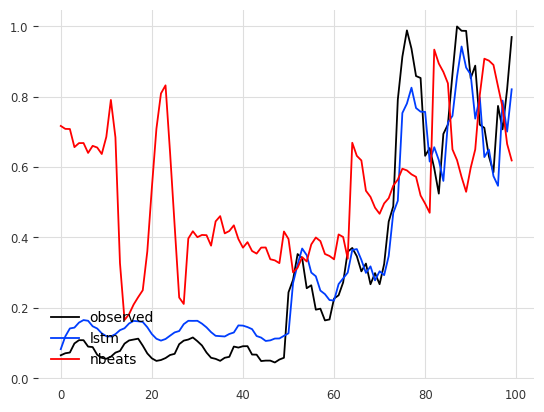

In [515]:
n=100
plt.plot(y_test.flatten()[-n:], label ='observed')
plt.plot(pred2.flatten()[-n:],label ='lstm')
plt.plot(air_preds_arr.flatten()[-n:], color = 'red',label ='nbeats')
plt.legend(loc='lower left')
plt.show()